<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Drift Detection: Text Summarization</h1>

**Overview**: In this example, we will see how to use UpTrain to monitor performance of a text summarization task in NLP. Summarization creates a shorter version of a document or an article that captures all the important information. For the same, we will be using a pretrained [text summarization model](https://huggingface.co/t5-small) (with T5 architecture) from [Huggingface](https://huggingface.co/docs/transformers/tasks/summarization). This model was trained on the [billsum dataset](https://huggingface.co/datasets/billsum).

**Why is monitoring needed**: Monitoring NLP tasks with traditional metrics (such as accuracy) in production is hard, as groud truth is unavailable (or extremely delayed when there is a human in the loop). And, hence, it becomes very important to develop techniques to monitor real time monitoring for tasks such as text summarization before important business metrics (such as customer satisfaction and revenue) are affected.

**Problem**: In this example, the model was trained on the [billsum dataset](https://huggingface.co/datasets/billsum). This dataset contains the articles and their summarization of the US Congressional and California state bills. However, in production, we append some samples from the [wikihow dataset](https://github.com/mahnazkoupaee/WikiHow-Dataset). The WikiHow is a large-scale dataset using the online [WikiHow](http://www.wikihow.com/) knowledge base. As you can imagine, the two datasets are quite different. It would be interesting to see how the text summarization task performs in production 🤔

**Solution**: We will be using UpTrain framework which provides an easy-to-configure way to log  training data, production data and model's predictions. We apply several techniques on theis logged data, such as clustering, data drift detection and customized signals, to monitor performance and raise alerts in case of any dip in model's performance 🚀

### Install Required packages
- [PyTorch](https://pytorch.org/get-started/locally/): Deep learning framework.
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/installation): To use pretrained state-of-the-art models.
- [Hugging Face Datasets](https://pypi.org/project/datasets/): Use public Hugging Face datasets
- [NLTK](https://www.nltk.org/install.html): Use NLTK for sentiment analysis

In [1]:
#!pip install uptrain torch transformers nltk datasets

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import uptrain
import json
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

from helper_funcs import *

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vipul/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Step 1: Setup - Defining model and datasets

### Define model and tokenizer for the summarization task

In [3]:
tokenizer_t5 = AutoTokenizer.from_pretrained("t5-small")
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
prefix = "summarize: "

### Load Billsum dataset from Huggingface which was used to train our model

In [4]:
billsum_dataset = load_dataset("billsum", split="ca_test").filter(lambda x: x['text'] is not None)
billsum = billsum_dataset.train_test_split(test_size=0.2)
billsum

Using custom data configuration default
Found cached dataset billsum (/Users/vipul/.cache/huggingface/datasets/billsum/default/3.0.0/75cf1719d38d6553aa0e0714c393c74579b083ae6e164b2543684e3e92e0c4cc)
Loading cached processed dataset at /Users/vipul/.cache/huggingface/datasets/billsum/default/3.0.0/75cf1719d38d6553aa0e0714c393c74579b083ae6e164b2543684e3e92e0c4cc/cache-10b05b1614ccfdc2.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 989
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 248
    })
})

### Download the wikihow dataset
Create a small test dataset from the [Wikihow](https://github.com/mahnazkoupaee/WikiHow-Dataset) dataset to test our summarization model. Download the wikihow dataset from https://ucsb.app.box.com/s/ap23l8gafpezf4tq3wapr6u8241zz358 and save it as 'wikihowAll.csv' in the current directory.

In [5]:
download_wikihow_csv_file()
wikihow_dataset = load_dataset("csv", data_files='wikihowAll.csv').filter(lambda x: x['text'] is not None)
wikihow_dataset = wikihow_dataset.rename_column("headline", "summary")
wikihow = wikihow_dataset['train'].train_test_split(test_size=453)
wikihow

wikihowAll.csv already present


Using custom data configuration default-284c260ed8a36aaa
Found cached dataset csv (/Users/vipul/.cache/huggingface/datasets/csv/default-284c260ed8a36aaa/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/vipul/.cache/huggingface/datasets/csv/default-284c260ed8a36aaa/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-09b0b890dc34f8fe.arrow


DatasetDict({
    train: Dataset({
        features: ['summary', 'title', 'text'],
        num_rows: 213841
    })
    test: Dataset({
        features: ['summary', 'title', 'text'],
        num_rows: 453
    })
})

### Create a test dataset by combining billsum and wikihow datasets

In [6]:
final_test_dataset = combine_datasets(billsum["test"], 'billsum_test', wikihow['test'], 'wikihow_test')
final_test_dataset

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['text', 'summary', 'title', 'dataset_label'],
    num_rows: 701
})

### Let's try out our model on one of the sample

In [7]:
sample_text = final_test_dataset.filter(lambda x: len(x["text"]) < 1000)['text'][0]
input_embs = tokenizer_t5(prefix + sample_text, truncation=True, padding=True, return_tensors="pt").input_ids
summary = tokenizer_t5.batch_decode(model_t5.generate(input_embs), skip_special_tokens=True)
print({"model_input_text_to_summarize": sample_text}, "\n")
print({"model_output_summary": summary})

  0%|          | 0/1 [00:00<?, ?ba/s]

{'model_input_text_to_summarize': " Also called muffler straps, muffler hangers are thick rubber loops. Your exhaust system may require more than 1 hanger, so look underneath the car to see if it requires any additional muffler hangers. Buy replacements for any that are broken or weakened.;\n, Let the muffler rest on a floor jack while you get the hanger ready in the following steps.\n\n, Some hangers might be constructed into 2 pieces, so make sure to remove all parts of the hanger.\n\n, First hang it from the top exhaust mount, which is attached to the bottom of your car. Let the muffler hanger dangle temporarily.\n\n, Pull up the muffler closer to the top exhaust mount so you can hook them together. Slide the handle through the muffler hanger, and hook the handle hole onto the exhaust mount located on the muffler. Slide the rubber muffler hanger along the wrench handle, and hook it over the muffler's exhaust mount.\n\n"} 

{'model_output_summary': ['muffler hangers are thick rubber 

## Using embeddings for model monitoring

To compare the two datasets, we will be utilizing text embeddings (generated by BERT). As we will see below, we can see clear differentiations between the two datasets in the embeddings space which could be an important metric to track drifts

#### Save bert embeddings for the training data

In [8]:
data_with_embs = generate_reference_dataset_with_embeddings(billsum['train'], tokenizer_t5, model_t5, dataset_label="billsum_train")
data_with_embs[0].keys()

dict_keys(['id', 'dataset_label', 'title', 'text', 'model_output', 'bert_embs', 'bert_embs_downsampled'])

## Step 2: Visualizing embeddings using UpTrain

Let's first visualize how does the embeddings of the training dataset compares against that of our real-world testing dataset. We use two dimensionality reduction techniques, UMAP and t-SNE, for embedding visualization.

In [9]:
config = {
    "checks": [
        {
        'type': uptrain.Visual.UMAP,
        "measurable_args": {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'bert_embs'
        },
        "label_args": {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'dataset_label'
        },
        'min_dist': 0.01,
        'n_neighbors': 20,
        'metric_umap': 'euclidean',
        'dim': '2D',
        # Frequency to Calculate UMAP 
        'update_freq': 100,
        'initial_dataset': "ref_dataset.json",
    },
    {
        'type': uptrain.Visual.TSNE,
        "measurable_args": {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'bert_embs'
        },
        "label_args": {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'dataset_label'
        },
        'dim': '2D',
        # Frequency to Calculate t-SNE 
        'update_freq': 100,
        'initial_dataset': "ref_dataset.json",
    }
    ],
    "logging_args": {"st_logging": True},
}

In [10]:
framework_umap = uptrain.Framework(cfg_dict=config)

batch_size = 25
all_summaries = []
all_bert_embs = []

for idx in range(int(len(final_test_dataset)/batch_size)):
    if idx % 4 == 0:
        print(idx*batch_size)

    this_batch = [prefix + doc for doc in final_test_dataset[idx*batch_size: (idx+1)*batch_size]['text']]

    # Text encoder
    input_embs = tokenizer_t5(this_batch, truncation=True, padding=True, return_tensors="pt").input_ids
    
    # Getting output values
    output_embs = model_t5.generate(input_embs)
    
    # Text decoder
    summaries = tokenizer_t5.batch_decode(output_embs, skip_special_tokens=True)
    all_summaries.append(summaries)

    bert_embs = convert_sentence_to_emb(summaries)
    all_bert_embs.append(bert_embs)

    inputs = {
        "text": this_batch,
        "bert_embs": bert_embs,
        "dataset_label": final_test_dataset[idx*batch_size: (idx+1)*batch_size]['dataset_label']
    }

    idens = framework_umap.log(inputs=inputs, outputs=summaries)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs_umap
0

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8509
  Network URL: http://192.168.6.64:8509

100
200
300
400
500
600


### UpTrain package includes two types of dimensionality reduction techniques: U-MAP and t-SNE

As we can clearly see, samples from the wikihow dataset form a different cluster compared to that of the training clusters from the billsum datasets. UpTrain gives a real-time dashboard of the embeddings of the inputs/outputs of your language models, helping you visualize these drifts before they start impacting your models.

#### 1. UMAP compression

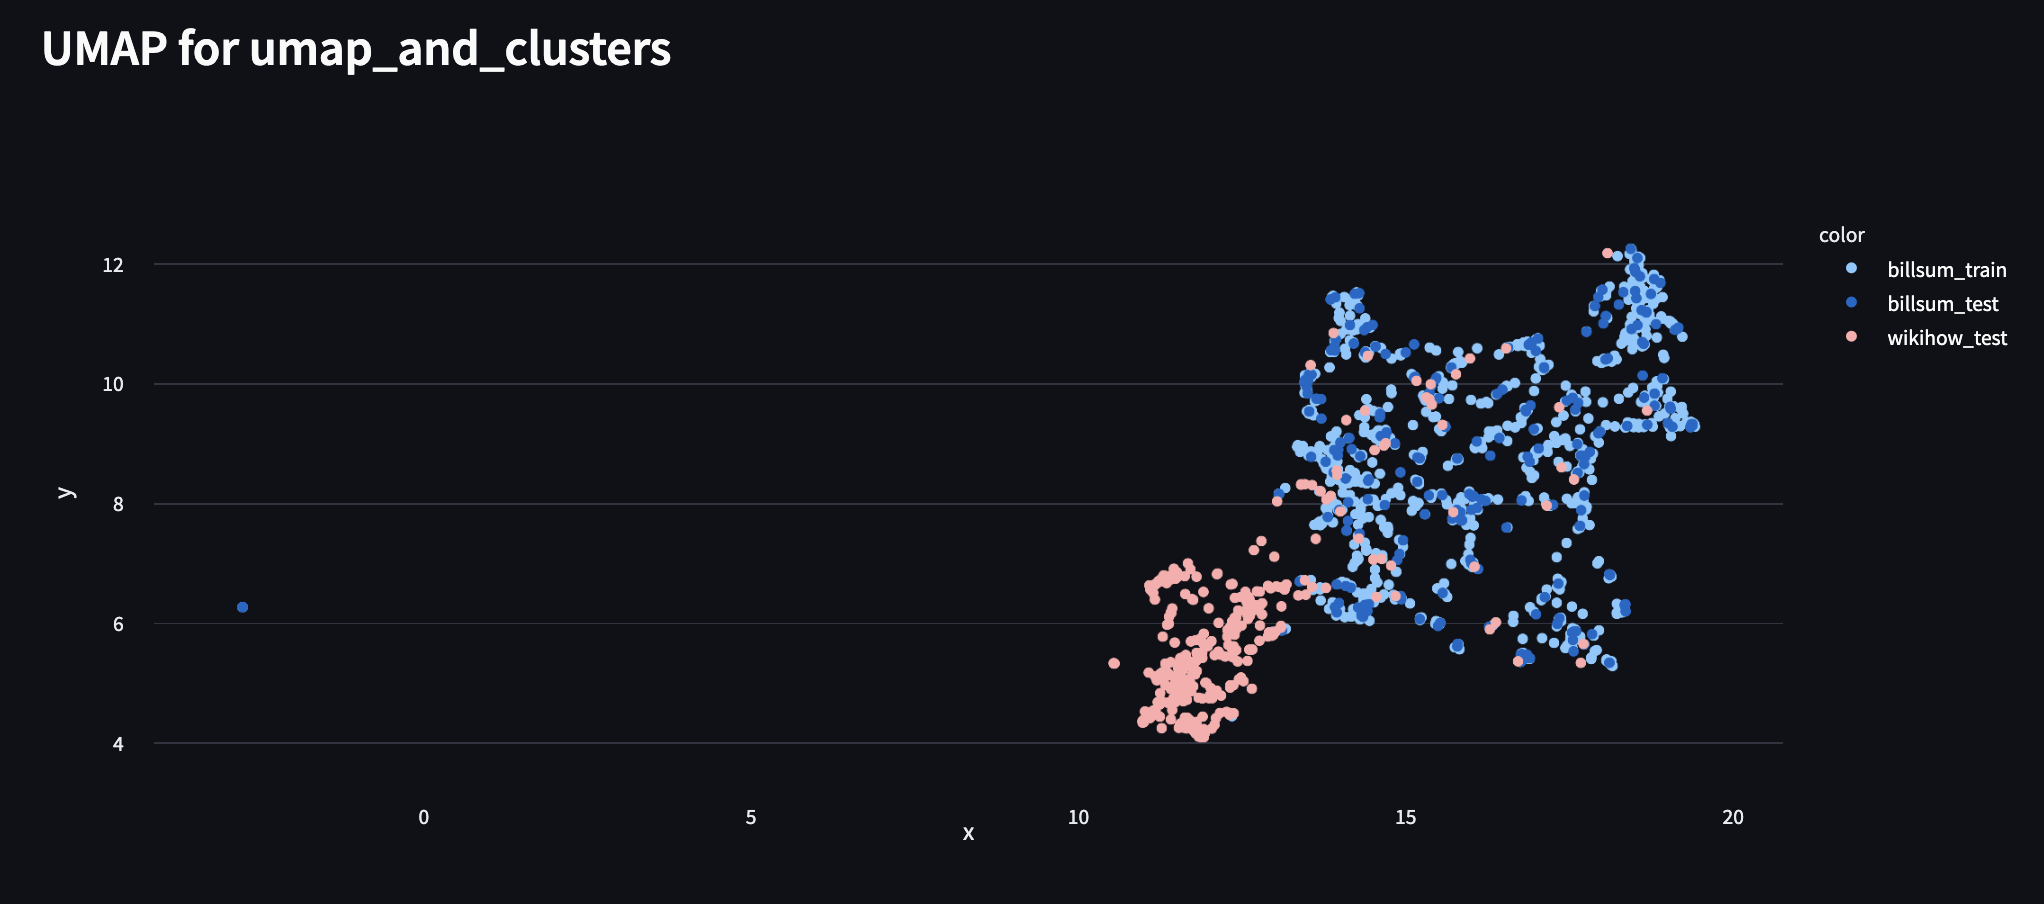

#### 2. t-SNE dimensionality reduction

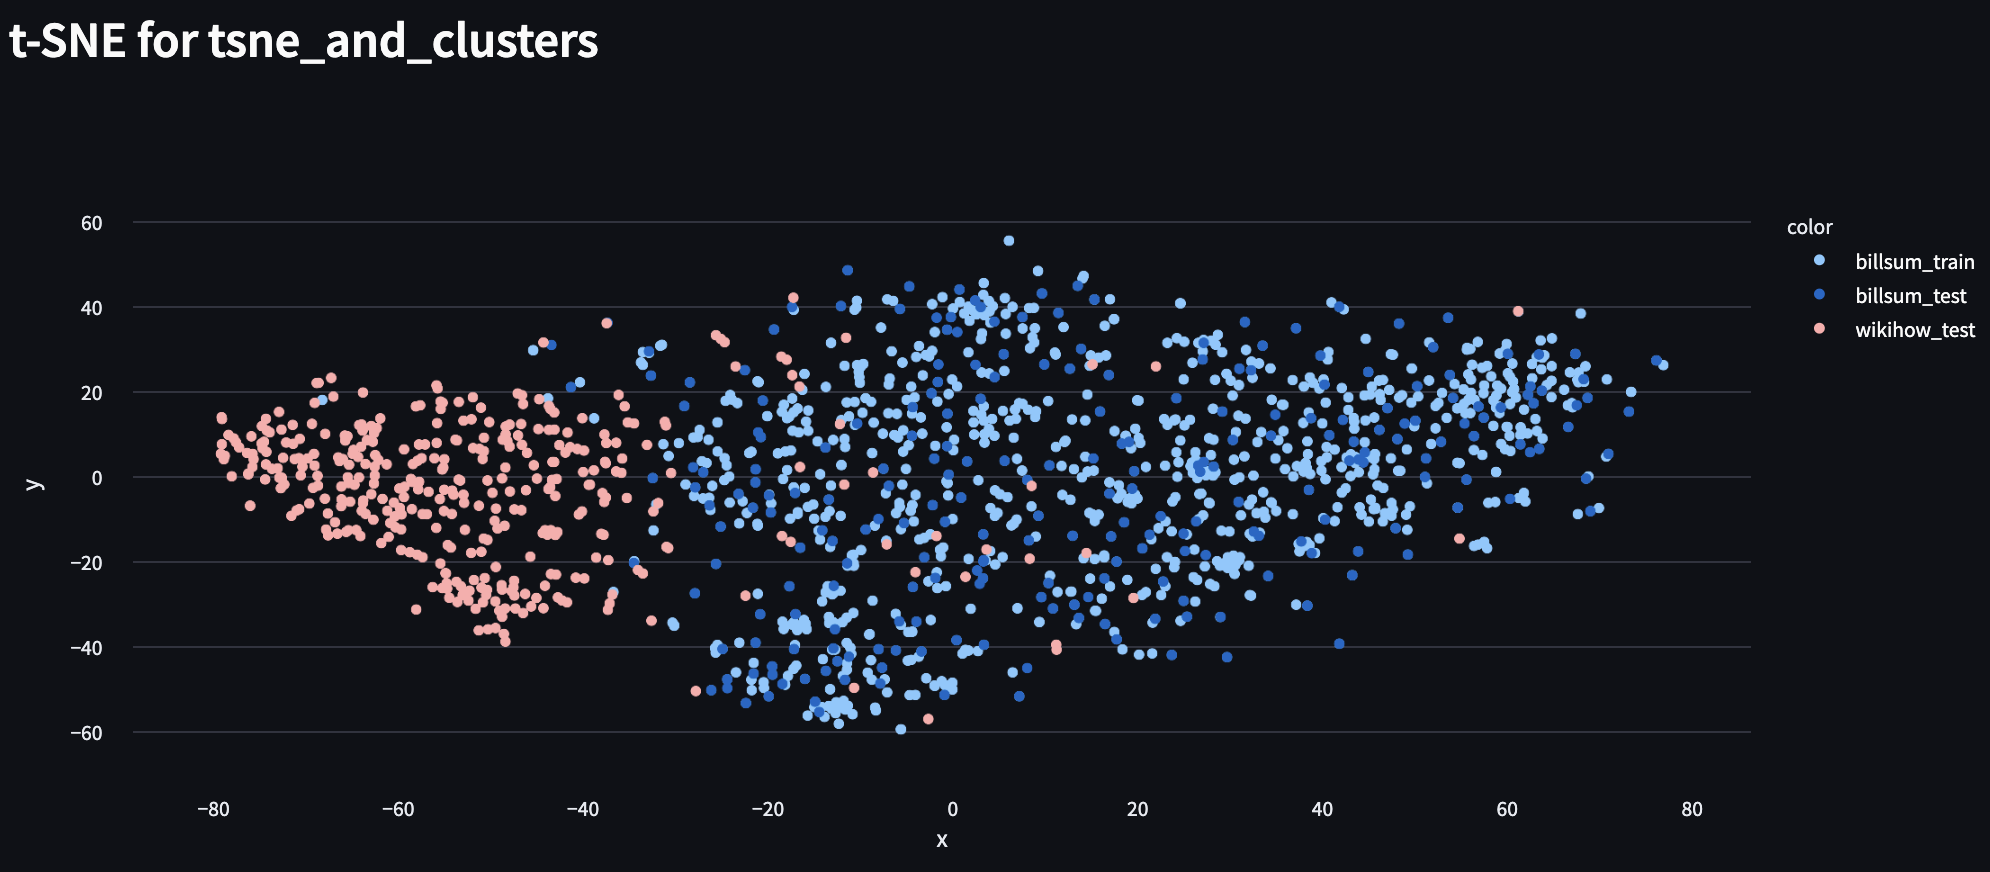

## Step 3: Quantifying Data Drift via embeddings

Now that we see embeddings belong to different clusters, we will see how to quantify (which could enable us to add Slack or Pagerduty alerts) using the data drift anomaly defined in UpTrain

#### Downsampling Bert embeddings

For the sake of simplicity, we are downsampling the bert embeddings from dim-384 to 16 by average pooling across features. 

In [11]:
config = {
    "checks": [{
        'type': uptrain.Anomaly.DATA_DRIFT,
        "measurable_args": {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'bert_embs_downsampled'
        },
        "is_embedding": True,
        'reference_dataset': "ref_dataset.json",
        "initial_skip": 50,
        "emd_threshold": 2
    }],
    "logging_args": {"st_logging": True},
}

In [12]:
framework_data_drift = uptrain.Framework(cfg_dict=config)

batch_size = 25

for idx in range(int(len(final_test_dataset)/batch_size)):
    this_batch = [prefix + doc for doc in final_test_dataset[idx*batch_size: (idx+1)*batch_size]['text'] if doc is not None]
    summaries = all_summaries[idx]
    bert_embs = all_bert_embs[idx]
    inputs = {
        "text": this_batch,
        "bert_embs_downsampled": downsample_embs(bert_embs),
        "dataset_label": final_test_dataset[idx*batch_size: (idx+1)*batch_size]['dataset_label']
    }
    
    idens = framework_data_drift.log(inputs=inputs, outputs=summaries)
    time.sleep(1)

print("Edge cases (i.e. points which are far away from training clusters, identified by UpTrain:")
collected_edge_cases = pd.read_csv(os.path.join("uptrain_smart_data", "1", "smart_data.csv"))
collected_edge_cases['output'].tolist()

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs_data_drift
Port 50001 is in use, trying port 50002.
Dashboard available at port 50002.
Edge cases (i.e. points which are far away from training clusters, identified by UpTrain:


['"you shouldn\'t make the whole game out of them but some of them can be."',
 '",,,,,,,,,,,,,,,,,,"',
 '"you can sew the fabric together on a machine or by hand. sew the"',
 '"do not lift your pencil until you are finished. Cross the upside-down \\"V\\""',
 '",,,,,,,,,,,,,,,,,,"',
 '"you must be original if you really want that huge fan base at your command. you"',
 '"use trapezoid shape with softer edges for the head. mark cross inside"',
 '"syncing multiple accounts can start to duplicate entries. calendar and contacts may begin to"',
 '",,,,,,,,,,,,,,,,,,,"',
 '",,,,,,,,,,,,,,,,,,"',
 '"press Ctrl+shift+C and type \\"testingcheatsenable"',
 '"brushes can be bought at pool table supply stores, recreation and hobby stores. use quick forward"',
 '"a cat is a Selkirk rex, but it can be difficult to"',
 '"the cable will be about 3 or 6 feet long and has 2 plugins on each end that"',
 '"in a large frying pan, heat the 4 tbsp of oil "']

UpTrain over-clusters the reference dataset, assigns cluster to the real-world data-points based on nearest distance and compares the two distributions using earth moving costs. As seen from below, the cluster assignment for the production dataset is significantly different from the reference dataset -> we are observing a significant drift in our data. 

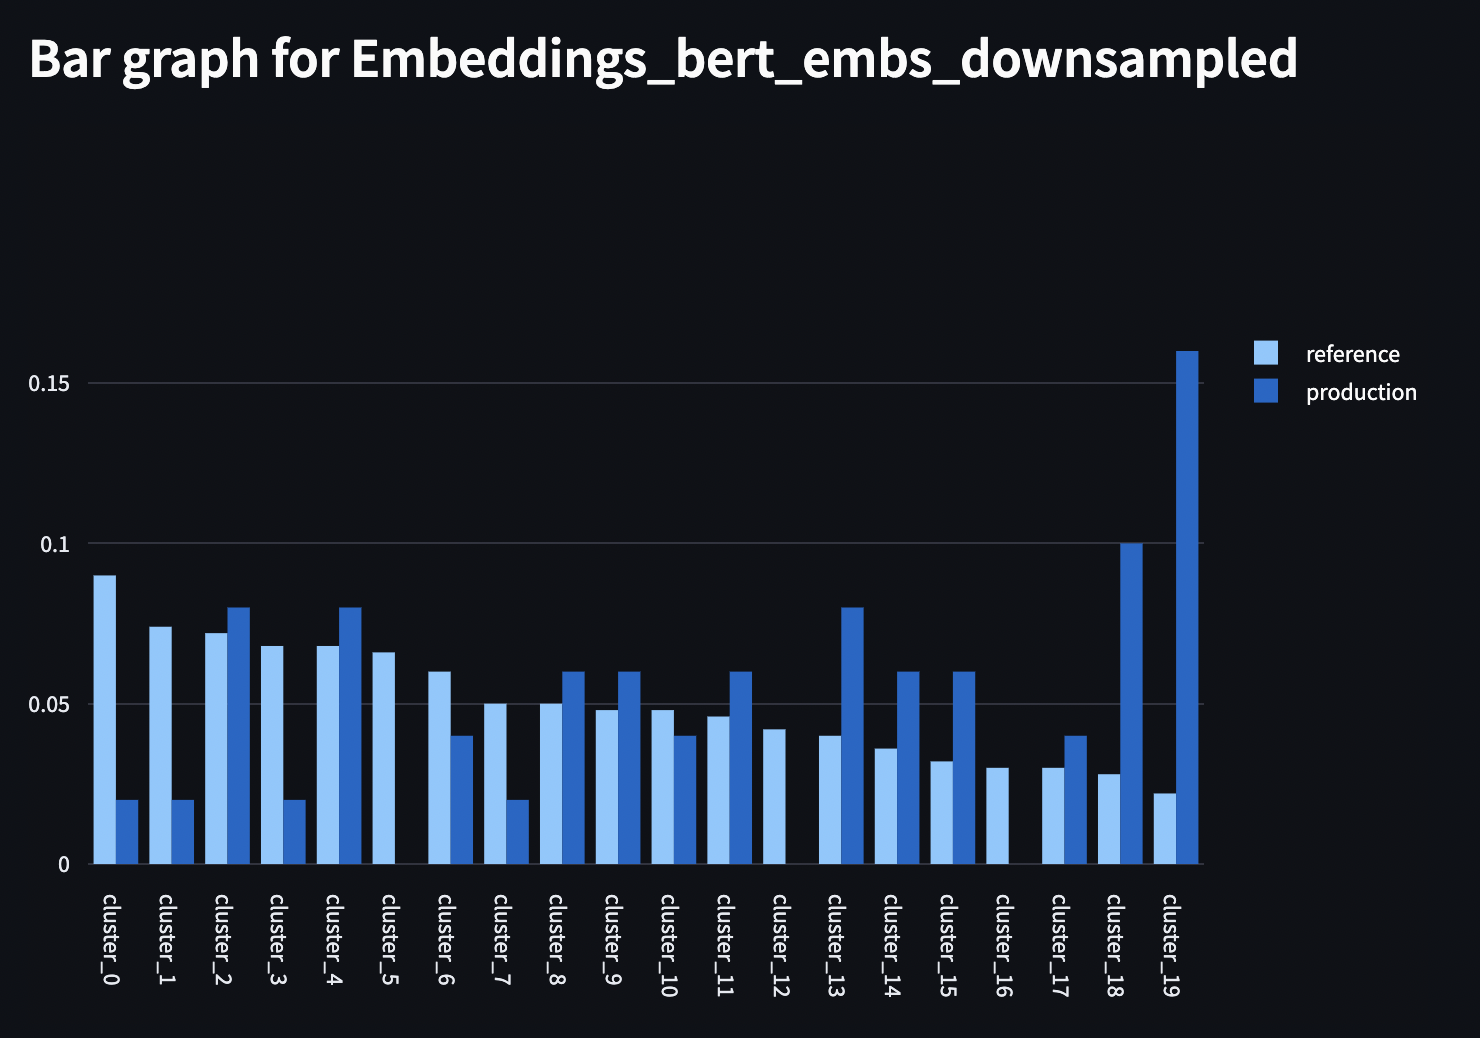

Now that we can visually make sense of the drift, UpTrain also provides a quantitative measure (Earth moving distance between the production and reference distribution) which can be used to alert whenever a significant drift is observed

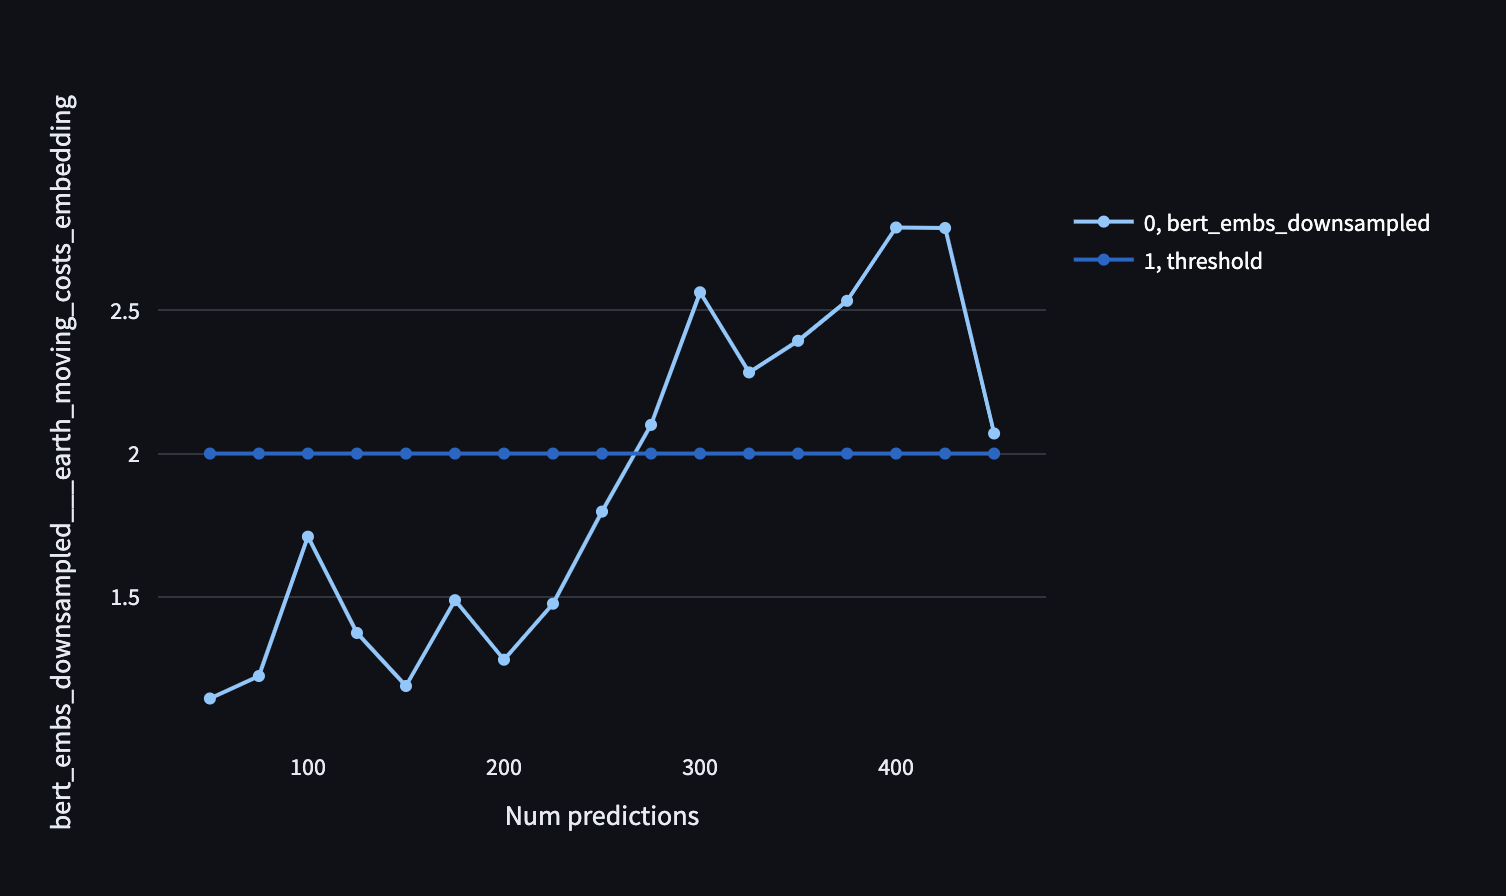

In addition to embeddings, UpTrain allows you to monitor drifts across any custom measure which one might care about. For example, in this case, we can monitor drift on metrics such as text language, user emotion, intent, occurence of a certain keyword, text topic, etc. 

## Step 4: Identifying edge cases

Now, that we have identified issues with our models, let's also see how can we use UpTrain to identify model failure cases. Since for out-of-distribution samples, we expect the model outputs to be wrong, we can define rules which can help us catch those failure cases. 

We will define two rules - Output is grammatically incorrect, and the sentiment of the output is negative (we don't expect negative setiment outputs on the wikihow dataset).

In [13]:
def grammar_check_func(inputs, outputs, gts=None, extra_args={}):
    is_incorrect = []
    for output in outputs:
        if output[-1] == "'":
            output = output[0:-1]
        output = output.lower()
        this_incorrect = False
        if ",,," in output:
            this_incorrect = True
        if output[-3:-1] == 'the':
            this_incorrect = True
        if output[-2:-1] in ['an', 'if']:
            this_incorrect = True
        is_incorrect.append(this_incorrect)
    return is_incorrect


def negative_sentiment_score_func(inputs, outputs, gts=None, extra_args={}):
    scores = []
    for input in inputs["text"]:
        txt = input.lower()
        sia = SentimentIntensityAnalyzer()
        scores.append(sia.polarity_scores(txt)['neg'])
    return scores

config = {
    "checks": [{
        'type': uptrain.Anomaly.EDGE_CASE,
        'signal_formulae': uptrain.Signal("Incorrect Grammer", grammar_check_func) 
            | (uptrain.Signal("Sentiment Score", negative_sentiment_score_func) > 0.5)
    }],
    "logging_args": {"st_logging": True},
}

In [14]:
framework_edge_cases = uptrain.Framework(cfg_dict=config)

batch_size = 25

for idx in range(int(len(final_test_dataset)/batch_size)):
    this_batch = [prefix + doc for doc in final_test_dataset[idx*batch_size: (idx+1)*batch_size]['text'] if doc is not None]
    summaries = all_summaries[idx]
    inputs = {
        "text": this_batch,
        "dataset_label": final_test_dataset[idx*batch_size: (idx+1)*batch_size]['dataset_label']
    }

    idens = framework_edge_cases.log(inputs=inputs, outputs=summaries)

collected_edge_cases = pd.read_csv(os.path.join("uptrain_smart_data", "1", "smart_data.csv"))
collected_edge_cases['output'].tolist(), collected_edge_cases['text'].tolist()

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs_edge_cases
Dashboard available at port 50002.


(['"old, mushy ones are fine too.,,,,,,,"',
  '",,,,,,,,,,,,,,,,,,"',
  '",,,,, four dangling sticks at the bottom of the oval body"',
  '",,,,,,,,,,,,,,,,,,"',
  '",,,,,,,,,,"',
  '",,,,,,,,,,"',
  '",,,,,,,,,,,,,,,,,,,"',
  '",,,,,,,,,,,,,,,,,,"'],
 ['"summarize:  Old, mushy ones are fine too provided they are not moldy.\\n\\n,,,,, Top up with milk.\\n\\n,"',
  '"summarize: ;\\n,,,,,,"',
  '"summarize: ;\\n,, do not go over your head though.\\n\\n\\nIf you want you can go funky and draw squiggly lines or swirls or dots!\\n\\n,,,, Four dangling sticks at the bottom of the oval body.\\n\\n, Draw a pointy stinger at the end of the bees body.\\n\\n,"',
  '"summarize: ;\\n,,,,,,"',
  '"summarize: ;\\n,,,"',
  '"summarize: ;\\n,,,"',
  '"summarize: ,,,,,,,,,,,"',
  '"summarize: ;\\n,,,,,,"'])

In this example, we saw how to identify distribution shifts in Natural language related tasks by taking advantage of text embeddings 